In [1]:
#..modified by CHUYAN at July23-2021; calculate binned P-E/SST /subsidence and LTS and LWP array;   (annual-mean, binned 5X5degree, area-mean data, 
#..standardized data)

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd


from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
#..retrieve variables in pi-control
#..SST
fpath_ts    = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ts/gn/v20190320/ts_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc' 
#..surface Temperature & Pressure
fpath_ps    = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ps/gn/v20190320/ps_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
fpath_tas   = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320/tas_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
#..temperature at levels
fpath_ta    = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ta/gn/v20190320/ta_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
#..liquid water path
fpath_clivi = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/clivi/gn/v20190320/clivi_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
fpath_clwvi = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/clwvi/gn/v20190320/clwvi_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
#..subsidence
fpath_wap   = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/wap/gn/v20190320/wap_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
#..precipitation flux and water evaporation flux
fpath_p     = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/pr/gn/v20190320/pr_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'
fpath_e     = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/evspsbl/gn/v20190320/evspsbl_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc'

f_ts        = netCDF4.Dataset(fpath_ts,'r')
f_ta        = netCDF4.Dataset(fpath_ta,'r')
f_tas       = netCDF4.Dataset(fpath_tas,'r')
f_ps        = netCDF4.Dataset(fpath_ps,'r')
f_wap       = netCDF4.Dataset(fpath_wap,'r')
f_clivi     = netCDF4.Dataset(fpath_clivi,'r')
f_clwvi     = netCDF4.Dataset(fpath_clwvi,'r')

f_pr        = netCDF4.Dataset(fpath_p, 'r')
f_ev        = netCDF4.Dataset(fpath_e, 'r')

lons        = f_ts.variables['lon'][:]
lats        = f_ts.variables['lat']
times       = f_ts.variables['time']


levels      = f_ta.variables['plev']
print(levels)

<class 'netCDF4._netCDF4.Variable'>
float64 plev(plev)
    axis: Z
    positive: down
    requested: 100000. 92500. 85000. 70000. 60000. 50000. 40000. 30000. 25000. 20000. 15000. 10000. 7000. 5000. 3000. 2000. 1000. 500. 100.
    standard_name: air_pressure
    title: pressure
    type: double
    units: Pa
unlimited dimensions: 
current shape = (19,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [3]:

#..choose lat 40-85S as the southern Ocean region
lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))


sfc_T       = f_ts.variables['ts']   #..T_skin, also as SST, shape in (1188, 192, 288), units in K
T_700        = f_ta.variables['ta'][:, 3,:,:]
sfc_P       = f_ps.variables['ps']   #..Units in Pa
sub         = f_wap.variables['wap'][:, 5,:,:]    #..500mb downward motions
clivi       = f_clivi.variables['clivi']   #..Units in kg m^-2
clwvi       = f_clwvi.variables['clwvi']
tas         = f_tas.variables['tas']   #..2-m air Temperature, for 'gmt'

P           = f_pr.variables['pr']   #..Units in kg m^-2 s^-1 = mm *s^-1
E           = f_ev.variables['evspsbl']
print(sfc_T.shape)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':


(1188, 192, 288)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()


In [4]:
Precip =  np.array(P) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip))   #..2.388
Eva    =  np.array(E) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva))         #..2.169
print(Eva.shape)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  """Entry point for launching an IPython kernel.


2.3886616


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


2.1690218
(1188, 192, 288)


In [5]:
#..Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP  = np.array(clwvi) - np.array(clivi)   #..units in kg m^-2

gmt  = np.array(tas)

SST  = np.array(sfc_T)

MC  = Precip-Eva   #..Moisture Convergence calculated from P - E, Units in mm day^-1


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  after removing the cwd from sys.path.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


In [6]:
#..Lower Troposphere Stability
k  = 0.286
theta_700  = np.array(T_700)* (100000./70000.)**k

#print(theta_700)

theta_skin = np.array(sfc_T)* (100000./np.array(sfc_P))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m
LTS_e  = np.ma.masked_where(theta_700 >= 500, LTS_m)
#print(LTS_e, LTS_m)

#..Subsidence, units in Pa s^-1 at 500 hPa
Subsidence =  np.array(sub)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys


In [7]:
#..Convert variables becoming Annual-mean, Southern-Ocean region arrays

Tg  = np.zeros((99,192,288))   #..Surface air Temperature, GMT
LWP_yr  = np.zeros((99,48,288))

p_e_yr  = np.zeros((99,48,288))
SST_yr  = np.zeros((99,48,288))
SUB_yr  = np.zeros((99,48,288))
LTS_yr  = np.zeros((99,48,288))
#..annual mean data of LWP, Tg and CCFs

for i in range(0, 99):
    Tg[i,:,:]     = np.nanmean(gmt[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr[i,:,:]  = np.nanmean(LWP[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr[i,:,:] = np.nanmean(MC[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr[i,:,:]    = np.nanmean(SST[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr[i,:,:]    = np.nanmean(LTS_e[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr[i,:,:]    = np.nanmean(Subsidence[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    

In [8]:
print(LWP_yr.shape)
#print(lat_array.shape,lon_array)

x_range  = np.arange(0., 364, 5.)   #..number:73
y_range  = np.arange(-85., -35, 5.)   #.. 40 S - 85 S(10)
xbins, ybins = len(x_range), len(y_range)

print(y_range.shape,xbins, ybins)


(99, 48, 288)
(10,) 73 10


In [9]:
def binned_cySouthOcean5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Southern Ocean region from 85S 40S
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-85., -35, 5.)   #.. (10)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [10]:
#..Calculate 5*5 binned array for variables(LWP, ccfs) in Sounthern Ocean region

lat_array  = lats[latsi1:latsi0]
lon_array  = lons

SST_yr_bin  = binned_cySouthOcean5(SST_yr, lat_array, lon_array)

p_e_yr_bin  = binned_cySouthOcean5(p_e_yr, lat_array, lon_array)
LWP_yr_bin  = binned_cySouthOcean5(LWP_yr, lat_array, lon_array)   #..shape in (99,10,73)

LTS_yr_bin  = binned_cySouthOcean5(LTS_yr, lat_array, lon_array)
SUB_yr_bin  = binned_cySouthOcean5(SUB_yr, lat_array, lon_array)

print(SUB_yr_bin.shape)   #..(99,10,73)

(99, 10, 73)


In [25]:
#..Ravel binned array / Standardized data ARRAY

LWP_predi  = LWP_yr_bin.flatten() 
#LWP_predi =  (LWP_predi - np.mean(LWP_predi) )/np.std(LWP_predi)

SST_predi  = SST_yr_bin.flatten()  
#SST_predi =  (SST_predi - np.mean(SST_predi)) /np.std(SST_predi)

p_e_predi =  p_e_yr_bin.flatten()
#p_e_predi =  (p_e_predi - np.mean(p_e_predi)) /np.std(p_e_predi)

LTS_predi  = LTS_yr_bin.flatten()
#LTS_predi =  (LTS_predi - np.nanmean(LTS_predi)) /np.nanstd(LTS_predi)

SUB_predi  = SUB_yr_bin.flatten()
#SUB_predi  = (SUB_predi - np.mean(SUB_predi)) /np.std(SUB_predi)

print(np.max(LTS_predi), np.max(SUB_predi))

#..Subtract 'nan' in data, 72270 -> 66598points
ind2 =  np.isnan(LTS_predi)==False
#print(ind2)

print(SUB_predi[ind2].shape)

nan 0.18562600786487263
(66598,)


In [26]:
#..Remove abnormal and missing_values:

X  = np.array([SST_predi[ind2], p_e_predi[ind2] ,LTS_predi[ind2], SUB_predi[ind2]])

print(X)
print(X.shape)

X2  = np.array([SST_predi[ind2], p_e_predi[ind2]])

[[2.26681901e+02 2.25504930e+02 2.24797933e+02 ... 2.84327553e+02
  2.84348557e+02 2.83876128e+02]
 [1.37956839e-01 1.26451916e-01 1.12827400e-01 ... 1.18650282e-01
  1.82366540e-01 4.49530225e-01]
 [9.75815859e+00 6.95421006e+00 4.05402970e+00 ... 1.36963827e+01
  1.34316585e+01 1.36239985e+01]
 [1.75817864e-02 1.67793967e-02 1.45882363e-02 ... 1.49331843e-02
  1.20111950e-02 8.22809406e-03]]
(4, 66598)


In [28]:
#..Multiple linear regreesion of Liquid water path(lwp) to (CCF)Cloud Controlling Factors:

result1 = LinearRegression().fit(X.T, LWP_predi[ind2])
print(result1.coef_)
print(result1.intercept_)

result1.score(X.T, LWP_predi[ind2])


#result1.predict()

[ 0.0022244   0.01740707 -0.00166793  0.02882105]
-0.49490642674103835


0.8385593310594059

In [29]:
#..Multiple linear regreesion of Liquid water path to CCF Cloud Controlling Factors:

result2 = LinearRegression().fit(X2.T, LWP_predi[ind2])
print(result2.coef_)
print(result2.intercept_)

result2.score(X2.T, LWP_predi[ind2])

[0.0023659  0.01781472]
-0.5559923187028606


0.818173002779718

In [30]:
coef1  = result1.coef_
np.save('sensitivity_4ccfs.npy', coef1)

intercept1  = result1.intercept_
np.save('intercept1.npy', intercept1)

In [31]:
coef2  = result2.coef_
np.save('sensitivity_2ccfs.npy', coef2)

(66598,)
(72270,)


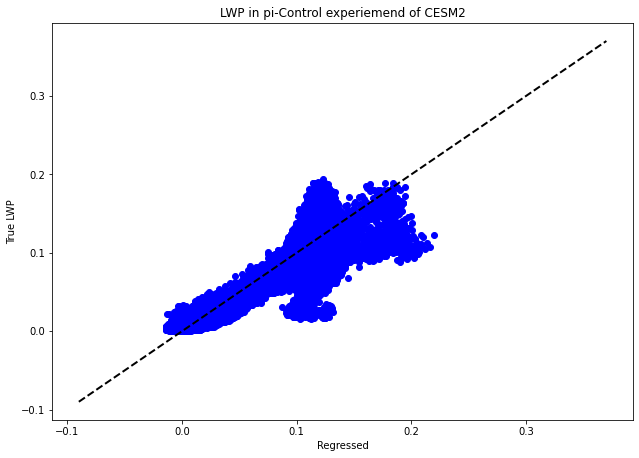

In [33]:
#..draw the plot for 'pi-Cont' experiment's LWP and the predicted LWP from linear Regression Model trained in 'pi-control'

fig2  = plt.figure(figsize = (10.4, 7.3))
ax2  = plt.axes()


apt  = np.dot(coef1, X)
cpt  = apt + intercept1


print(cpt.shape)
print(LWP_predi.shape)
plt.scatter(cpt.flatten(), LWP_predi[ind2], c  = 'b')
#..Add reference LINE
x  = np.linspace(-0.09, 0.37, 50)
y  = x
plt.plot(x, y, color='k', linewidth =2, linestyle =  'dashed')

#plt.ylim((0.105, 0.121))


plt.xlabel('Regressed')
plt.ylabel('True LWP')
plt.title("LWP in pi-Control experiemend of CESM2")


plt.savefig("LWP_distribution_CESM2.png")

In [17]:
fpath_abr_ts    = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_ta    = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/latest/ta_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_ps    = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/latest/ps_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_wap   = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/wap/gn/latest/wap_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_clivi = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/clivi/gn/latest/clivi_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_clwvi = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/clwvi/gn/latest/clwvi_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_tas   = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'

fpath_p     = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/pr_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.n'
fpath_e     = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/evspsbl/gn/v20190927/evspsbl_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'

In [18]:
#..Test..
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])

x1 = np.random.normal(0.,1.,size=100,)

a =  0.8
b =  np.sqrt(1. - a**2)
x2 =  []

In [19]:
for i in np.arange(0,100,1):
    x2.append(a*x1[i] + b* np.random.normal(0., 1., 1))

x3  = np.asarray(x2)
#print(x2)
print(x3)

[[ 0.91057394]
 [-0.07875968]
 [-1.71252511]
 [-0.64977282]
 [-0.32943044]
 [ 1.91496669]
 [ 0.45783101]
 [-1.00932278]
 [ 1.00118399]
 [-0.41990868]
 [ 1.56096437]
 [ 0.73558039]
 [-0.40029257]
 [-0.03310703]
 [-0.33182266]
 [ 0.57999047]
 [-0.25566302]
 [-0.15665203]
 [ 1.12001766]
 [-1.79120878]
 [ 0.96582511]
 [ 0.56178179]
 [-0.37137532]
 [-0.02873189]
 [-0.0871223 ]
 [ 0.82040149]
 [ 0.14816891]
 [ 1.87954132]
 [ 0.0107897 ]
 [-0.99055028]
 [ 0.62762477]
 [-2.31945047]
 [ 1.24494363]
 [ 0.84465171]
 [-0.66339404]
 [-0.08238222]
 [-0.19852728]
 [-0.08143935]
 [ 1.70058789]
 [-0.0045731 ]
 [-1.44843324]
 [ 2.56492287]
 [ 0.2263234 ]
 [ 0.06736285]
 [-0.80274066]
 [-1.07050042]
 [-0.67868484]
 [ 1.56387498]
 [-2.27863146]
 [ 0.1418725 ]
 [-0.20216137]
 [-1.28378883]
 [ 0.41476623]
 [-0.18573178]
 [ 1.17627469]
 [ 0.5376106 ]
 [-0.10628367]
 [-2.473915  ]
 [-0.95969353]
 [ 0.45449921]
 [-0.29912333]
 [-1.00008504]
 [-0.35464517]
 [ 1.70035099]
 [ 0.04239985]
 [-3.20474546]
 [-0.91685

In [20]:
x = [0.1, 0.55, 0.1, 0.6, 0.1,0.3, 0.6]
y = [2.1, 2.6, 2.1, 2.1,  2.6,2.3 , 2.3]
binx = [0.0, 0.5, 1.0]
biny = [2.0, 2.5, 3.0]
ret = stats.binned_statistic_2d(x, y, None, 'count', bins=[binx, biny], expand_binnumbers = True)

print(ret.statistic)
ret.binnumber

[[3. 1.]
 [2. 1.]]


array([[1, 2, 1, 2, 1, 1, 2],
       [1, 2, 1, 1, 2, 1, 1]])